# Complexity Reduction
In this tutorial, we will demonstrate the complexity reduction framework of PyBigDFT. We will begin with the notion of fragment observables by extracting some quantities from a calculation. Then we will introduce the notion of fragment purity to determine the quality of a given fragmentation. We will then present the fragment bond order as a means of quantifying fragment interaction and building interaction graphs. Finally, we will use all of that information to automatically partition a system into fragments.

## System Preparation
First we need a system to use an an example. We will start with a CO2 molecule.

In [1]:
from BigDFT.IO import XYZReader
from BigDFT.Systems import System
from BigDFT.Fragments import Fragment

sys = System()
sys["CO2:0"] = Fragment()

with XYZReader("CO2") as ifile:
    for at in ifile:
        sys["CO2:0"].append(at)

In [2]:
from BigDFT.IO import write_pdb
with open("CO2.pdb", "w") as ofile:
    write_pdb(sys, ofile)

Let's put that in a water box using the [PDB](https://github.com/openmm/pdbfixer) fixer program.

In [3]:
from os import system
from os.path import exists

# So you don't have to recalculate!
if not exists("test.pdb"):
    system("pdbfixer  CO2.pdb --water-box=1 1 1 --output test.pdb")

In [4]:
from BigDFT.IO import read_pdb
with open("test.pdb") as ifile:
    sys = read_pdb(ifile)

Visualize the system we created.

In [5]:
from BigDFT.Visualization import InlineVisualizer
viz = InlineVisualizer(400,300)
viz.display_system(sys)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## System Calculation
Now we need to perform a calculation of the system of interest. The key ingredients are to use the linear scaling mode and to write the matrices to file.

In [6]:
from BigDFT.Inputfiles import Inputfile
inp = Inputfile()
inp.set_hgrid(0.4)
inp.set_xc("PBE")
inp.write_support_function_matrices()
inp["import"] = "linear"

In [7]:
from BigDFT.Calculators import SystemCalculator
code = SystemCalculator(verbose=False, skip=True)

Initialize a Calculator with OMP_NUM_THREADS=4 and command mpirun -np 1 /Users/wddawson/Documents/CEA/binaries/bds/install/bin/bigdft


In [8]:
log = code.run(input=inp, posinp=sys.get_posinp(), name="cr2", run_dir="work")

After doing a calculation, we need to associate a system with the values that were computed by our BigDFT Calculation.

In [9]:
sys.set_logfile_info(log)

## Examining System Properties
Let's take a look at some of the properties of our system. For example, the fragment charges.

Text(0.5, 1.0, 'Fragment Net Charges')

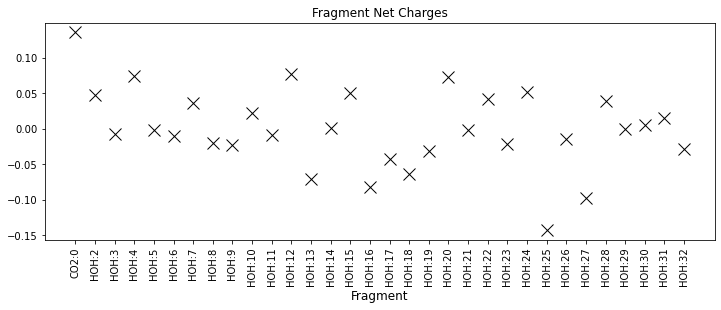

In [10]:
from BigDFT.Systems import plot_fragment_information
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1,1, figsize=(12,4))

data = {x: [y.qcharge - y.nel] for x, y in sys.items()}
plot_fragment_information(axs, data)
axs.set_title("Fragment Net Charges")

The dipole of a fragment.

Text(0.5, 1.0, 'Fragment Dipole Strength')

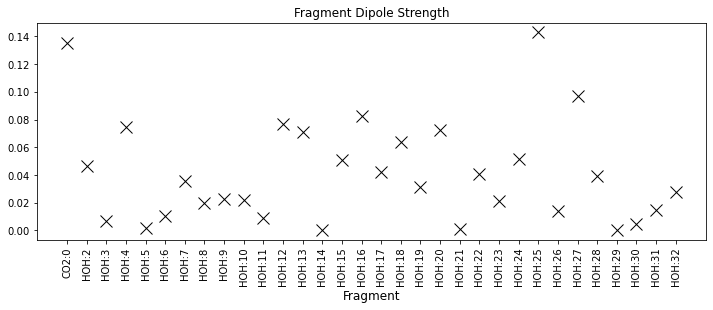

In [11]:
from numpy.linalg import norm
fig, axs = plt.subplots(1,1, figsize=(12,4))
data = {x: norm(y.q0) for x, y in sys.items()}
plot_fragment_information(axs, data)
axs.set_title("Fragment Dipole Strength")

Or the the net force on any of the fragments.

Text(0.5, 1.0, 'Fragment Net Force')

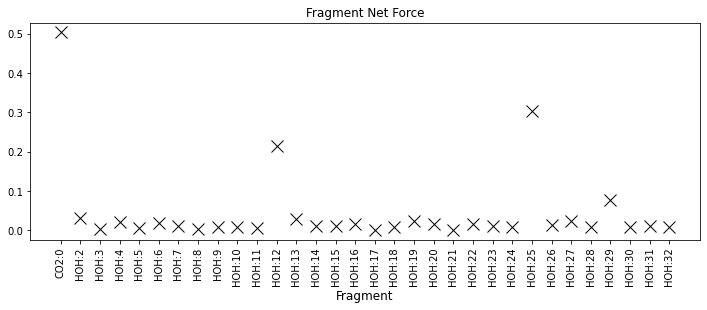

In [12]:
fig, axs = plt.subplots(1,1, figsize=(12,4))
data = {x: norm(y.get_net_force()) for x, y in sys.items()}
plot_fragment_information(axs, data)
axs.set_title("Fragment Net Force")

## Fragment Purity
The purity indicator is a measure of how good a given fragment is. It measures the balance between its interaction with itself an its interaction with other molecules. We can extract purity values for each of the fragments in our system. The BigDFTool will give us access to these values.

In [13]:
from BigDFT.PostProcessing import BigDFTool
btool = BigDFTool()

In [14]:
purities = btool.run_compute_purity(sys, log)

Text(0.5, 1.0, 'Fragment Purities')

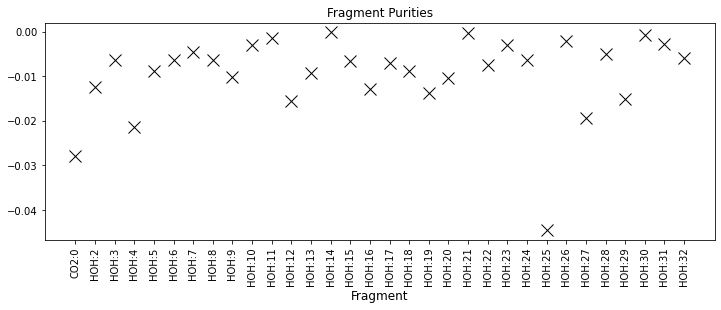

In [15]:
fig, axs = plt.subplots(1,1, figsize=(12,4))
plot_fragment_information(axs, purities)
axs.set_title("Fragment Purities")

## Fragment Bond Order

The fragment bond order represents a measure of the interaction between any given two fragments. Together with the purity and the charges of a system, we can create a FragmentView object.

In [16]:
from BigDFT.Systems import FragmentView
charges = {fragid: sum(at.nel for at in frag) for fragid, frag in sys.items()}
bo = btool.fragment_bond_order(sys, sys, sys, log)
view = FragmentView(purities, bo, charges)

Let's visualize this interaction by creating a graph view of the system using the fragment bond order.

In [17]:
from BigDFT.BioQM import Graph
g = Graph(list(sys), bo, [x.replace(":","\n") for x in sys])

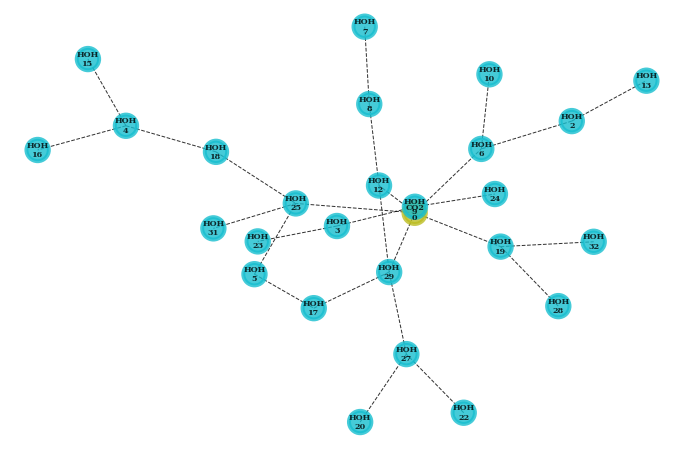

In [18]:
colors = ["tab:olive" if "CO" in x else "tab:cyan" for x in sys]
fig, axs = plt.subplots(1,1,figsize=(12,8))
axs.axis("off")
g.display(node_size=500, font_size=8, axs=axs, alpha=0.8, colors=colors, style='--')

Sometimes it might be hard to see the fragment we are actually interested in.

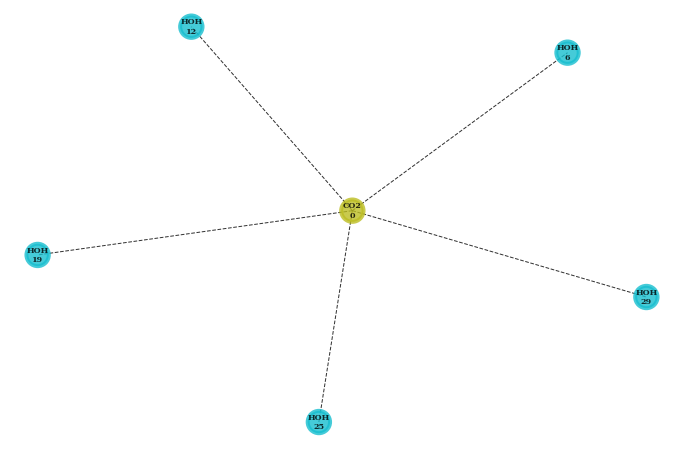

In [19]:
g = Graph(list(sys), bo, [x.replace(":","\n") for x in sys], restrict_to=["CO2:0"])
colors = []
for fragid in sys:
    if "CO" in fragid:
        colors.append("tab:olive")
    else:
        colors.append("tab:cyan")
fig, axs = plt.subplots(1,1,figsize=(12,8))
axs.axis("off")
g.display(node_size=500, font_size=8, axs=axs, alpha=0.8, colors=colors, style='--')

## Auto Fragmentation.

Sometimes, we wish to re-organize the system with a stricter criteria for what kind of fragments we will use. This can be done automatically by the BIgDFTool.

In [20]:
mapping = btool.auto_fragment(sys, view, 0.01)
print(mapping)

{'HOH:30': ['HOH:30'], 'HOH:10': ['HOH:10'], 'HOH:27+HOH:20': ['HOH:27', 'HOH:20'], 'HOH:22': ['HOH:22'], 'HOH:23': ['HOH:23'], 'HOH:3': ['HOH:3'], 'HOH:32': ['HOH:32'], 'HOH:11': ['HOH:11'], 'HOH:6': ['HOH:6'], 'HOH:17': ['HOH:17'], 'HOH:29+HOH:12+HOH:25+CO2:0': ['HOH:29', 'HOH:12', 'HOH:25', 'CO2:0'], 'HOH:2+HOH:13': ['HOH:2', 'HOH:13'], 'HOH:31': ['HOH:31'], 'HOH:9+HOH:24': ['HOH:9', 'HOH:24'], 'HOH:19+HOH:28': ['HOH:19', 'HOH:28'], 'HOH:5': ['HOH:5'], 'HOH:26': ['HOH:26'], 'HOH:21': ['HOH:21'], 'HOH:18': ['HOH:18'], 'HOH:8': ['HOH:8'], 'HOH:4+HOH:16': ['HOH:4', 'HOH:16'], 'HOH:15': ['HOH:15'], 'HOH:14': ['HOH:14'], 'HOH:7': ['HOH:7']}


In [21]:
newsys = System()
for f1, frag_list in mapping.items():
    newsys[f1] = Fragment()
    for f2 in frag_list:
        newsys[f1] += sys[f2]
new_view = view.refragment(mapping)

We can verify the new purity values.

Text(0.5, 1.0, 'Refragmented Purities')

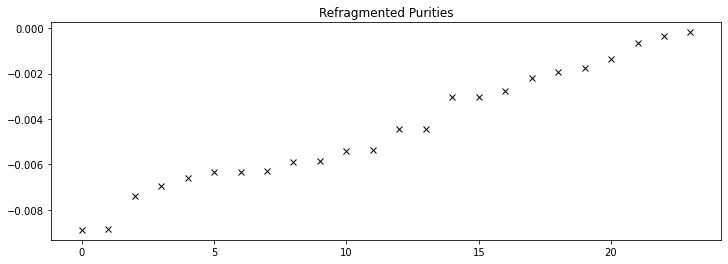

In [22]:
fig, axs = plt.subplots(1,1, figsize=(12,4))
axs.plot(sorted(list(new_view.purities.values())), 'kx')
axs.set_title("Refragmented Purities")

And visualize the refragmented system.

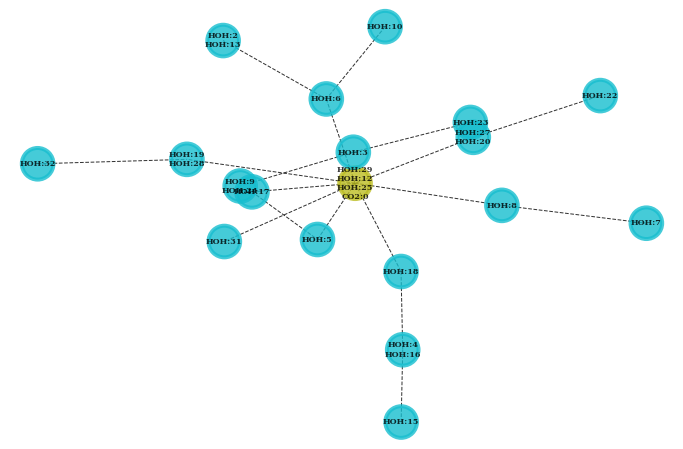

In [23]:
g = Graph(list(newsys), new_view.bond_orders, [x.replace("+","\n") for x in newsys])
colors = ["tab:olive" if "CO" in x else "tab:cyan" for x in newsys]
fig, axs = plt.subplots(1,1,figsize=(12,8))
axs.axis("off")
g.display(node_size=1000, font_size=8, axs=axs, alpha=0.8, colors=colors, style='--')